In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
class OrderParameter:

    # name should be unique to the Order Parameter being defined
    # In other words for every possible pair of OP's x and y, (x.name != y.name) must be true
    def __init__(self, name, traj):
        self.name = name
        self.traj = traj
        
    def __eq__(self, other):
        return self.name == other.name
    
    def __hash__(self):
        return hash(self.name)
        
    def __str__(self):
        return str(self.name)

In [3]:
def distortion(centers, ops, mut):
    dis = 0.0
    for i in ops:
        min_val = np.inf
        for j in centers:
            tmp = mut.iqr(i, j)
            if tmp < min_val:
                min_val = tmp
        dis = dis + (min_val * min_val)
    return 1 + (dis ** (0.5))

In [4]:
class DissimilarityMatrix:

    def __init__(self, max_OPs, mut):
        self.max_OPs = max_OPs
        self.matrix = [[] for i in range(max_OPs)]
        self.mut = mut
        self.OPs = []

    def add_OP(self, OP):
        if len(self.OPs) == self.max_OPs:
            mut_info = []
            existing = []
            for i in range(len(self.OPs)):
                mut_info.append(self.mut.iqr(self.OPs[i], OP))
                product = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        product = product * self.matrix[i][j]
                existing.append(product)
            update = False
            difference = None
            for i in range(len(self.OPs)):
                candidate_info = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        candidate_info = candidate_info * mut_info[j]
                if candidate_info > existing[i]:
                    update = True
                    if difference == None:
                        difference = candidate_info - existing[i]
                        old_OP = i
                    else:
                        if (candidate_info - existing[i]) > difference:
                            difference = candidate_info - existing[i]
                            old_OP = i
            if update == True:
                mut_info[old_OP] = self.mut.iqr(OP, OP)
                self.matrix[old_OP] = mut_info
                self.OPs[old_OP] = OP
                for i in range(len(self.OPs)):
                    self.matrix[i][old_OP] = mut_info[i]
        else:
            for i in range(len(self.OPs)):
                mut_info = self.mut.iqr(OP, self.OPs[i])
                self.matrix[i].append(mut_info)
                self.matrix[len(self.OPs)].append(mut_info)
            self.matrix[len(self.OPs)].append(self.mut.iqr(OP, OP))
            self.OPs.append(OP)
        
    def reduce(self):
        min_val = 10
        index = -1
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                index = i
                min_val = product
        self.matrix.pop(index)
        for i in range(len(self.matrix)):
            self.matrix[i].pop(index)
        self.OPs.pop(index)
        
    def min_product(self):
        min_val = 10
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                min_val = product
        return min_val
    
    def get_OPs(self):
        return self.OPs
    
    def __str__(self):
        output = ""
        output = output + "OPs:\n"
        for i in self.OPs:
            output = output + str(i) + "\n"
        output = output + "\nMatrix:\n"
        for i in self.matrix:
            for j in i:
                output = output + str(j) + " "
            output = output + "\n"
        return output
                

In [5]:
def d1_bin(x, bins = 80):

    min_val = np.amin(x)
    max_val = np.amax(x)
    span = max_val - min_val

    p_x = [0.0 for i in range(bins)]

    for i in x:
        bin_num = (int) (bins * (i - min_val) / span)
        if bin_num == bins:
            bin_num -= 1
        p_x[bin_num] += 1.0 / len(x)

    return p_x

In [6]:
def d2_bin(x, y, bins = 80):

    if len(x) != len(y):
        raise Exception("Order parameter lists are of different size.")

    min_x = np.amin(x)
    max_x = np.amax(x)
    span_x = max_x - min_x

    min_y = np.amin(y)
    max_y = np.amax(y)
    span_y = max_y - min_y

    p_xy = [[0.0 for i in range(bins)] for j in range(bins)]

    for i in range(len(x)):
        bin_x = (int) (bins * (x[i] - min_x) / span_x)
        bin_y = (int) (bins * (y[i] - min_y) / span_y)
        if bin_x == bins:
            bin_x -= 1
        if bin_y == bins:
            bin_y -= 1
        p_xy[bin_x][bin_y] += 1.0 / len(x)

    return p_xy

In [7]:
class Memoizer:
    
    def __init__(self):
        self.memo = {}
        self.bins = 80
        
    def iqr(self, OP1, OP2):
        index = str(OP1.name) + " " + str(OP2.name)
        if index in self.memo:
            return self.memo[index]
        else:
            x = OP1.traj
            y = OP2.traj
            p_x = d1_bin(x, self.bins)
            p_y = d1_bin(y, self.bins)
            p_xy = d2_bin(x, y, self.bins)

            info = 0
            entropy = 0

            for i in range(len(p_x)):
                for j in range(len(p_y)):
                    if p_xy[i][j] != 0:
                        entropy -= p_xy[i][j] * np.log(p_xy[i][j])
                        info += p_xy[i][j] * np.log(p_xy[i][j] / (p_x[i] * p_y[j]))

            if ((1 - (info / entropy)) < 0):
                output = 0.0
            else:
                output = (1 - (info / entropy))
            self.memo[index] = output
            return output
    
    def __str__(self):
        print(len(self.memo))

In [8]:
def grouping(new_OPs, all_OPs, mut):
    groups = [[] for i in range(len(new_OPs))]
    for OP in all_OPs:
        group = 0
        for i in range(len(new_OPs)):
            tmp = mut.iqr(OP, new_OPs[i])
            if tmp < mut.iqr(OP, new_OPs[group]):
                group = i
        groups[group].append(OP)
    return groups

In [9]:
def group_evaluation(OPs, mut):
    
    center = OPs[0]
    min_distortion = distortion([OPs[0]], OPs, mut)
    
    for i in OPs:
        tmp = distortion([i], OPs, mut)
        if tmp < min_distortion:
            center = i
            min_distortion = tmp

    return center

In [10]:
def cluster(ops, seeds, mut):
    
    old_centers = []
    centers = copy.deepcopy(seeds)
    
    while (set(centers) != set(old_centers)):
        
        old_centers = copy.deepcopy(centers)
        centers = []
        groups = grouping(old_centers, ops, mut)
        
        for i in range(len(groups)):
            result = group_evaluation(groups[i], mut)
            centers.append(result)

    return centers


In [11]:
def find_ops(old_ops, max_outputs):
    
    mut = Memoizer()
    matrix = DissimilarityMatrix(max_outputs, mut)
    
    for i in old_ops:
        matrix.add_OP(i)
        
    for i in old_ops[::-1]:
        matrix.add_OP(i)
    
    tmp = copy.deepcopy(matrix)
    distortion_array = []
    num_array = []
    str_num_array = []

    while (len(tmp.OPs) > 0):
        num_array.append(len(tmp.OPs))
        str_num_array.append(str(len(tmp.OPs)))
        seed = []
        for i in tmp.OPs:
            seed.append(i)
        tmp_ops = cluster(old_ops, seed, mut)
        distortion_array.append(distortion(tmp_ops, old_ops, mut))
        tmp.reduce()
    
    plt.plot(str_num_array, distortion_array)
    plt.xlabel("Number of OPs")
    plt.ylabel("Distortion")
    plt.show()
    
    jumps = []
    
    for dim in range(1,11):
        neg_expo = np.array(distortion_array) ** (-0.5 * dim)
        plt.plot(str_num_array, neg_expo, label=str(-0.5 * dim))
        local = []
        for j in range(len(neg_expo) - 1):
            local.append(neg_expo[j] - neg_expo[j + 1])
        jumps.append(local)
    
    plt.xlabel("Number of Order Parameters")
    plt.ylabel("Distortion with Neg. Expo")
    plt.legend()
    plt.show()
    
    jump_num_array = []
    for i in range(len(str_num_array) - 1):
        jump_num_array.append(str_num_array[i])
        
    for i in range(len(jumps)):
        plt.plot(jump_num_array, jumps[i], label=str(-0.5 * (i + 1)))
        
    plt.xlabel("Number of Order Parameters")
    plt.ylabel("Jump in Distortion with Neg. Expo")
    plt.legend()
    plt.show()
    
    num_ops = 0
    
    for dim in range(1,11):
        neg_expo = np.array(distortion_array) ** (-0.5 * dim)
        jumps = []
        for i in range(len(neg_expo) - 1):
            jumps.append(neg_expo[i] - neg_expo[i + 1])
            
        min_index = 0
        for i in range(len(jumps)):
            if jumps[i] > jumps[min_index]:
                min_index = i
        if num_array[min_index] > num_ops:
            num_ops = num_array[min_index]
        
    while (len(matrix.OPs) > num_ops):
        matrix.reduce()
        
    centers = cluster(old_ops, matrix.OPs, mut)
    groups = grouping(centers, old_ops, mut)
    
    for i in range(len(centers)):
        print("Center: " + centers[i].name)
        for OP in groups[i]:
            print(OP.name)
        print()
    
    return centers


In [12]:
def gen_two():
    traj = []
    for i in range(5000):
        tmp = random.random()
        tmp = 1 - (tmp * tmp * tmp * tmp)
        if random.random() < 0.5:
            tmp = -1 * tmp
        traj.append(tmp)
    return traj

In [13]:
def gen_three():
    traj = []
    for i in range(5000):
        tmp = random.random()
        tmp = (tmp * tmp * tmp * tmp)/2
        if random.random() < 0.5:
            tmp = 1 - tmp
        if random.random() < 0.5:
            tmp = -1 * tmp
        traj.append(tmp)
    return traj

In [14]:
def add_noise(traj):
    new_traj = []
    for i in traj:
        new_traj.append(i + (random.random() / 10) - 0.05)
    return new_traj

In [15]:
def rand_insert(lst, ele):
    lst.insert(random.randrange(len(lst) + 1), ele)

In [16]:
def make_OP(name, num, num_wells, ops):
    
    original = None
    if num_wells == 2:
        original = gen_two()
    elif num_wells == 3:
        original = gen_three()
    else:
        raise Exception("I've only built in distribution generators for 2 and 3 well OP's.")
        
    rand_insert(ops, OrderParameter(name, original))
    
    for i in range(num - 1):
        rand_insert(ops, OrderParameter(name + str(i + 1), add_noise(original)))
        
    return None
        

In [17]:
ops = []
make_OP("A", 14, 2, ops)
make_OP("B", 10, 2, ops)
make_OP("C", 14, 3, ops)
make_OP("D", 10, 3, ops)
make_OP("E", 14, 2, ops)
make_OP("F", 10, 2, ops)
make_OP("G", 14, 2, ops)
make_OP("H", 10, 3, ops)
make_OP("I", 14, 3, ops)
make_OP("J", 10, 2, ops)

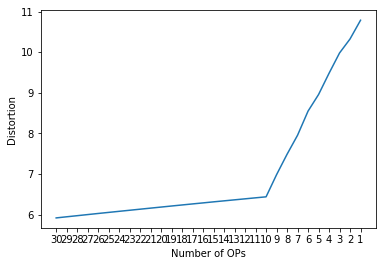

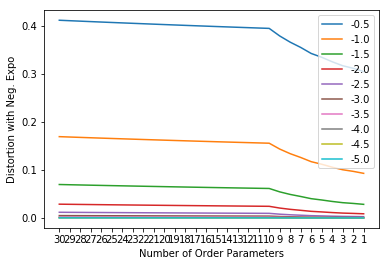

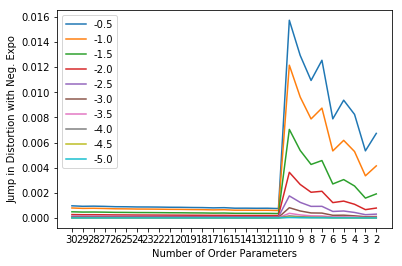

Center: F
F4
F2
F
F9
F5
F7
F8
F6
F3
F1

Center: G
G9
G2
G12
G6
G3
G1
G8
G
G13
G10
G5
G4
G7
G11

Center: D
D6
D7
D9
D3
D1
D5
D8
D
D4
D2

Center: A
A12
A8
A1
A6
A4
A10
A9
A13
A
A11
A7
A5
A3
A2

Center: B
B5
B4
B3
B8
B
B9
B6
B2
B7
B1

Center: J
J8
J6
J5
J2
J7
J1
J9
J
J3
J4

Center: H
H2
H4
H5
H8
H6
H7
H3
H9
H
H1

Center: E
E7
E8
E9
E2
E5
E10
E1
E6
E13
E3
E4
E12
E
E11

Center: I
I9
I8
I
I6
I4
I10
I5
I7
I2
I11
I3
I1
I13
I12

Center: C
C8
C6
C2
C3
C1
C11
C7
C
C9
C10
C5
C4
C13
C12



In [18]:
final_ops = find_ops(ops, 30)

In [19]:
print("Number of Order Parameters: " + str(len(final_ops)))
for i in final_ops:
    print(i.name)
print("\nAll order Parmeters:")
for i in ops:
    print(i.name)

Number of Order Parameters: 10
F
G
D
A
B
J
H
E
I
C

All order Parmeters:
J8
H2
G9
F4
F2
C8
H4
B5
E7
H5
F
E8
D6
A12
A8
J6
C6
F9
B4
J5
B3
E9
H8
E2
H6
I9
G2
D7
C2
E5
G12
A1
E10
A6
C3
D9
G6
D3
A4
F5
J2
I8
B8
C1
G3
E1
C11
H7
J7
G1
B
B9
D1
I
G8
A10
F7
I6
E6
I4
B6
B2
G
I10
A9
G13
J1
I5
A13
H3
A
C7
B7
C
I7
C9
I2
I11
H9
J9
D5
H
F8
A11
F6
G10
E13
D8
C10
B1
A7
E3
D
I3
E4
F3
G5
D4
D2
E12
C5
J
F1
G4
I1
E
I13
G7
A5
I12
E11
A3
C4
J3
J4
G11
H1
A2
C13
C12
